In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import os
import numpy as np
import func
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./instance/model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./instance/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(test_generator)
# print('test loss, test acc:', results)

Found 39900 images belonging to 3 classes.



It tooks 41 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
Canon_Ixus70,3024,21,7
Olympus_mju-1050SW,18,3039,4
Nikon_D200,3,5,6679


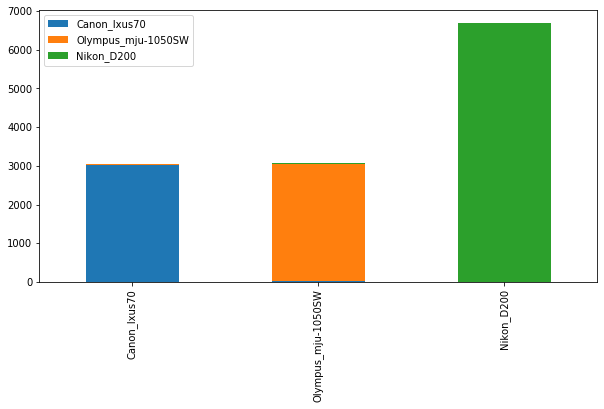

In [5]:
model_list = os.listdir(r'./instance/test/')
# generate a histogram, which for every unseen models, how many imgs are classified.
hist, conf, labels = func.evaluate(model_list, test_generator, model, index=model_list, columns=model_list, title=None, num_batch=200)

The mean of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.987378,0.009719,0.002903
1.0,0.010897,0.985930,0.003173
2.0,0.001343,0.002060,0.996597


The standard deviation of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.084685,0.069160,0.040377
1.0,0.071278,0.082260,0.038105
2.0,0.016832,0.024301,0.032666


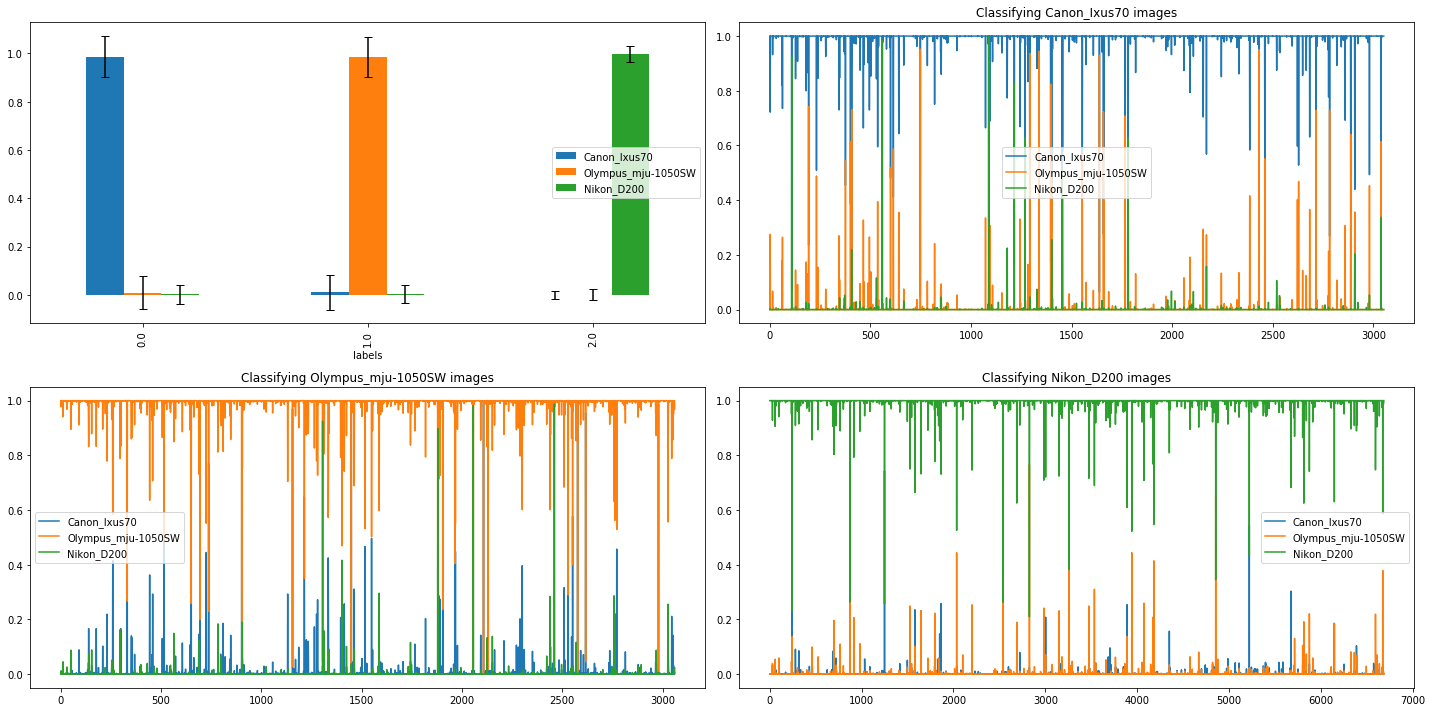

In [6]:
labels = np.hstack((labels))
conf = np.vstack((conf))
df = pd.DataFrame(np.hstack((np.expand_dims(labels, axis=1), conf)), columns=['labels']+model_list)
print('The mean of the confidence is: \n')
mean = df.groupby(['labels']).mean()
display(mean)
print('The standard deviation of the confidence is: \n')
error = df.groupby(['labels']).std()
display(error)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
mean.plot.bar(yerr=error, ax=axes[0,0], capsize=4)

# for all the images' real label is a certain camera, for example Canon_Ixus70, 
# how does these images are classified ? The magnitude of the histogram indicate how
# sure is the model classified the image as one camera(show by color)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
for i in range(len(model_list)):
    weights = []
    idx = np.hstack(np.argwhere(labels==i))
    for j in range(len(model_list)):
        weights.append([i[j] for i in conf[idx]])
    df = pd.DataFrame(np.array(weights).transpose(), columns=model_list)
    df.plot( title='Classifying ' + model_list[i] + ' images', ax=graph[i])
plt.tight_layout()